<a href="https://colab.research.google.com/github/alheir/nnii-cv/blob/main/tp02_datacentric_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 - Datacentric CV

25.87 - Redes Neuronales II

> Computer Vision


Alumno: HEIR, Alejandro Nahuel

Legajo: 62496

e-mail: aheir@itba.edu.ar

Utilizando la siguiente librería [ImageNet Datasets Downloader](https://github.com/mf1024/ImageNet-Datasets-Downloader)

1. Bajar imágenes de 20 clases.
2. Instanciar una ResNet-18
    * Loss = "categorical_crossentropy"
    * Optimizer = "adam"
    * Early Stopping
    * ReduceLearningRateOnPlateau
    * ModelCheckPoint
3. Entrenar el modelo optimizando los HP anteriores.
4. A partir de ahora, sin modificar los parámetros anteriores, reentrenar el modelo utilizando distintas técnicas de aumentación (desde el mismo punto, preentrenado con imagenet).
    * Utilizar siempre el mismo conjunto de datos para validación (estos no se aumentan)
5. Para la mejor performance que hayan obtenido, informar el pipeline de aumentación que utilizaron.

*Bonus: hacer búsqueda de hiperparámetros automática con MLFlow y Tensorboard.*

# Paquetes y módulos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests

import os
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

!pip install -U albumentations --quiet
import albumentations as A

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 656.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.7/680.7 kB 30.4 MB/s eta 0:00:00


# ImageNet Datasets Downloader

## Descarga del dataset

In [2]:
n_classes = 20

In [ ]:
# # https://github.com/mf1024/ImageNet-Datasets-Downloader/pull/25
# !git clone https://github.com/mafernandezGI/ImageNet-Datasets-Downloader.git

Cloning into 'ImageNet-Datasets-Downloader'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 127 (delta 5), reused 9 (delta 4), pack-reused 113 (from 1)
Receiving objects: 100% (127/127), 1.58 MiB | 12.80 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
# !python ImageNet-Datasets-Downloader/downloader.py \
#     -data_root ./ \
#     -number_of_classes 1 \
#     -images_per_class 100 \
#     # -multiprocessing_workers 8

Picked the following clases:
['rear admiral']
Scraping images for class "rear admiral"
Multiprocessing workers: 8


In [3]:
files_fn = 'tp2-imagenet_images.zip'
files_url = 'https://downloads.sourceforge.net/project/dsp-fpga-dip-nn-itba/nn/tp2-imagenet_images.zip'

!wget -nc {files_url} -O {files_fn}

!unzip -o {files_fn}

# !rm {files_fn}

--2024-11-01 20:34:29--  https://downloads.sourceforge.net/project/dsp-fpga-dip-nn-itba/nn/tp2-imagenet_images.zip
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Connecting to downloads.sourceforge.net (downloads.sourceforge.net)|204.68.111.105|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://psychz.dl.sourceforge.net/project/dsp-fpga-dip-nn-itba/nn/tp2-imagenet_images.zip?viasf=1 [following]
--2024-11-01 20:34:29--  https://psychz.dl.sourceforge.net/project/dsp-fpga-dip-nn-itba/nn/tp2-imagenet_images.zip?viasf=1
Resolving psychz.dl.sourceforge.net (psychz.dl.sourceforge.net)... 208.87.241.191
Connecting to psychz.dl.sourceforge.net (psychz.dl.sourceforge.net)|208.87.241.191|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125922528 (120M) [application/octet-stream]
Saving to: ‘tp2-imagenet_images.zip’

tp2-imagenet_images 100%[===================>] 120.09M  37.4MB/s    in 3.2s    

2024-1

In [4]:
images_root_path = "imagenet_images/"

folder_list = os.listdir(images_root_path)
folder_list.sort()
print(folder_list)

print()

print(f"Cantidad de directorios: {len(folder_list)}")

print()

for folder in folder_list:
  folder_path = os.path.join(images_root_path, folder)
  file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
  print(f"Directorio: {folder}, Cantidad de archivos: {file_count}")

['California fuchsia', 'air compressor', 'automat', 'backseat', 'button', 'kitty', 'lederhosen', 'muntjac', 'pine nut', 'powdered sugar', 'protractor', 'rabbit', 'rear admiral', 'red pine', 'shantung', 'spike', 'tobacco shop', 'tugboat', 'wash', 'weathervane']

Cantidad de directorios: 20

Directorio: California fuchsia, Cantidad de archivos: 95
Directorio: air compressor, Cantidad de archivos: 87
Directorio: automat, Cantidad de archivos: 92
Directorio: backseat, Cantidad de archivos: 101
Directorio: button, Cantidad de archivos: 107
Directorio: kitty, Cantidad de archivos: 100
Directorio: lederhosen, Cantidad de archivos: 105
Directorio: muntjac, Cantidad de archivos: 99
Directorio: pine nut, Cantidad de archivos: 95
Directorio: powdered sugar, Cantidad de archivos: 117
Directorio: protractor, Cantidad de archivos: 99
Directorio: rabbit, Cantidad de archivos: 100
Directorio: rear admiral, Cantidad de archivos: 106
Directorio: red pine, Cantidad de archivos: 103
Directorio: shantung, 

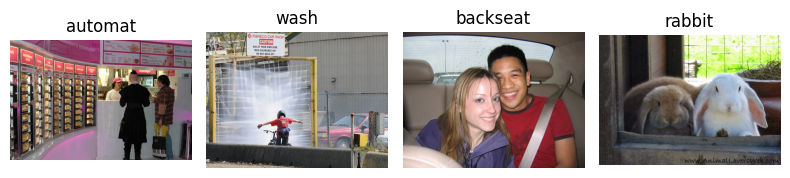

In [5]:
num_images_to_plot = 4

plt.figure(figsize=(8, 6))

for i in range(num_images_to_plot):
    random_folder = random.choice(folder_list)
    folder_path = os.path.join(images_root_path, random_folder)
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(folder_path, random_image)
        try:
          img = Image.open(image_path)
          plt.subplot(1, num_images_to_plot, i+1)
          plt.imshow(img)
          plt.title(random_folder)
          plt.axis('off')
        except Exception as e:
          print(f"Error al procesar la imagen {image_path}: {e}")
    else:
      print(f"La carpeta {random_folder} no contiene imágenes.")

plt.tight_layout()
plt.show()

## Carga del dataset

In [6]:
batch_size = 32
img_size = (224, 224)

train_ds = image_dataset_from_directory(
    images_root_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical'
)

val_ds = image_dataset_from_directory(
    images_root_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical'
)

print()

print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")

Found 1998 files belonging to 20 classes.
Using 1599 files for training.
Found 1998 files belonging to 20 classes.
Using 399 files for validation.

Train dataset size: 50
Validation dataset size: 13


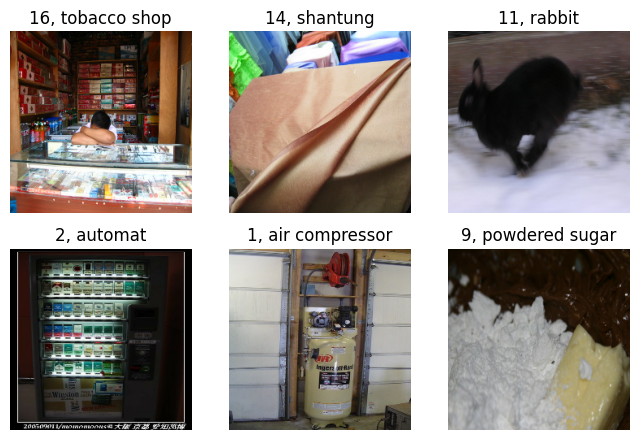

In [7]:
num_images_to_plot = 6

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(num_images_to_plot):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(labels[i])
    plt.title(f'{index}, {folder_list[index]}')
    plt.axis("off")

In [8]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))

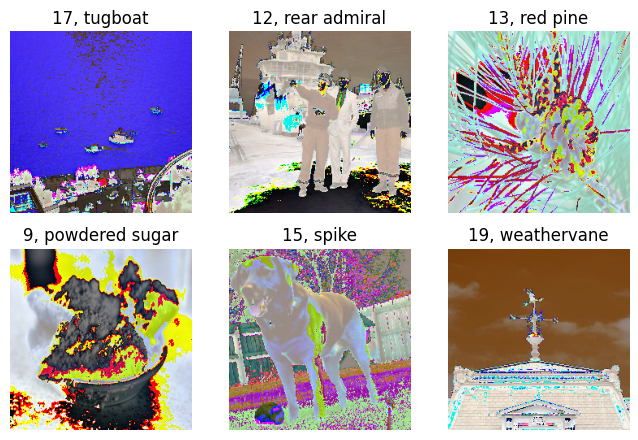

In [9]:
num_images_to_plot = 6

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(num_images_to_plot):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(labels[i])
    plt.title(f'{index}, {folder_list[index]}')
    plt.axis("off")

# ResNet50

## Instancia

In [10]:
# Instanciar la ResNet50 sin preentrenamiento
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Agregar capas superiores personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Capa adicional
predictions = Dense(n_classes, activation='softmax')(x)

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,706,388 (98.06 MB)

 Trainable params: 25,653,268 (97.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 1er entrenamiento

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.0576 - loss: 5.3793 - val_accuracy: 0.0576 - val_loss: 20.2514 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 387ms/step - accuracy: 0.1272 - loss: 2.8651 - val_accuracy: 0.0802 - val_loss: 3.0593 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - accuracy: 0.1758 - loss: 2.7165 - val_accuracy: 0.1178 - val_loss: 2.9547 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - accuracy: 0.2082 - loss: 2.5596 - val_accuracy: 0.1328 - val_loss: 2.8385 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 437ms/step - accuracy: 0.2566 - loss: 2.4650 - val_accuracy: 0.1930 - val_loss: 2.7168 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - accuracy: 0.2776 - loss: 2.3553 - val_accuracy: 0.1905 - val_loss: 2.5738 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - accuracy: 0.2856 - loss: 2.2

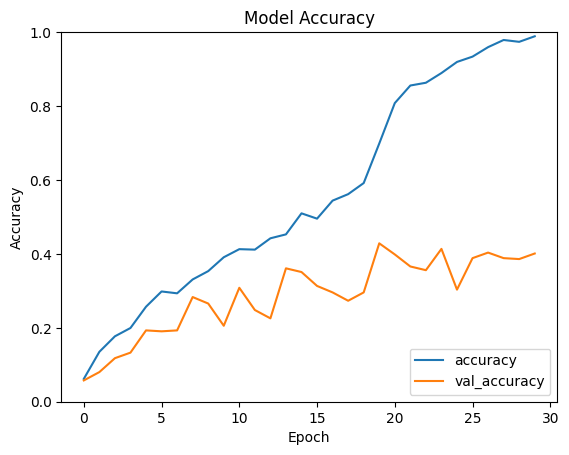

In [11]:
# Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('prebest_model.keras', monitor='val_accuracy', save_best_only=True)
]

# Definición de los hiperparámetros para el entrenamiento
epochs = 50

# Entrenar el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

# Mostrar la historia de entrenamiento
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

## Augmentation

In [22]:
augmentation_pipelines = {
    "pipeline_1": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussNoise(var_limit=(10, 50), p=0.3),  # Añadir ruido gaussiano
    ]),
    "pipeline_2": A.Compose([
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.GaussNoise(var_limit=(10, 30), p=0.4),
        A.RandomBrightnessContrast(p=0.5),
        A.Blur(blur_limit=3, p=0.3),  # Aplicar desenfoque
    ]),
    "pipeline_3": A.Compose([
        A.Rotate(limit=30, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=0, p=0.5),
        A.RandomCrop(height=200, width=200, p=1),
        A.Resize(height=224, width=224, p=1),  # Redimensionar después de recortar
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Jitter de color
    ]),
    "pipeline_4": A.Compose([
        A.Rotate(limit=30, p=0.5),
        A.RandomCrop(height=200, width=200, p=0.5),
        A.Resize(height=224, width=224, p=1),  # Redimensionar después de recortar
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),  # Ruido multiplicativo
        A.ElasticTransform(alpha=1.0, sigma=50, p=0.5),  # Transformación elástica
    ])
}

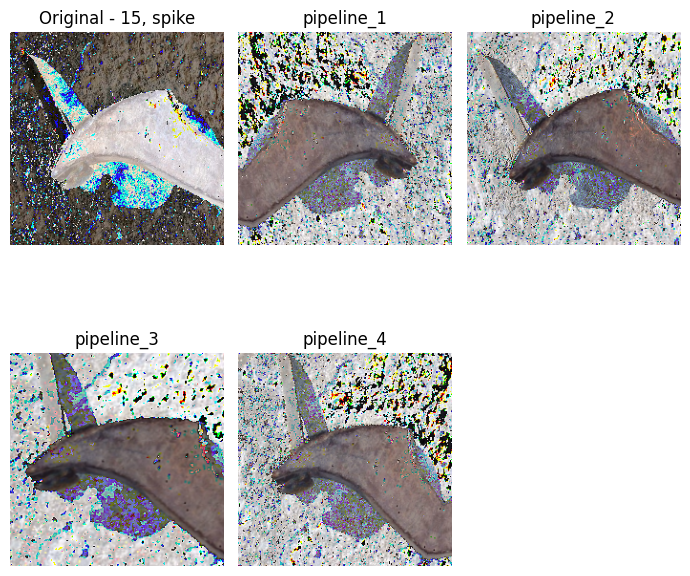

In [24]:
def apply_augmentation(image, pipeline):
    image = image.numpy().astype("uint8")
    image = Image.fromarray(image)
    image = np.array(image)
    augmented = pipeline(image=image)['image']
    augmented = preprocess_input(np.expand_dims(augmented, axis=0))
    return augmented[0]

for images, labels in train_ds.take(1):
  sample_image = images[0]
  sample_label = labels[0]
  break

plt.figure(figsize=(7, 7))
plt.subplot(2, 3, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
index = np.argmax(sample_label)
plt.title(f'Original - {index}, {folder_list[index]}')
plt.axis("off")

for i, (name, pipeline) in enumerate(augmentation_pipelines.items()):
    augmented_image = apply_augmentation(sample_image, pipeline)
    plt.subplot(2, 3, i + 2)
    plt.imshow(augmented_image.astype("uint8"))
    plt.title(name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [25]:
# 1. Cargar los pesos del mejor modelo
model.load_weights('prebest_model.keras')

In [26]:
# Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('augbest_model.keras', monitor='val_accuracy', save_best_only=True)
]

In [29]:
# Definir un generador de datos que aplica aumentación
def augmented_data_generator(dataset, augmentations, batch_size, steps_per_epoch):
    while True:
        for images, labels in dataset.take(steps_per_epoch):
            # Verificar si las imágenes tienen tamaño válido
            if images.shape[0] == 0:
                continue  # Saltar si no hay imágenes

            augmented_images = []
            for img in images.numpy():
                augmented = augmentations(image=img)
                augmented_images.append(augmented['image'])

            yield np.array(augmented_images), labels.numpy()

def train_with_augmentation(augmentation, model, train_ds, val_ds):
    # Asegurarse de que el generador de datos esté bien configurado
    steps_per_epoch = len(train_ds)# // BATCH_SIZE
    validation_steps = len(val_ds)# // BATCH_SIZE

     # Repetir el dataset para evitar quedarse sin datos
    train_ds = train_ds.repeat()  # Repetir el dataset
    val_ds = val_ds.repeat()      # Repetir el dataset también para la validación

    # Entrenamiento del modelo
    history = model.fit(
        augmented_data_generator(train_ds, augmentation, batch_size, steps_per_epoch),
        validation_data=val_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=callbacks
    )

    return history

In [30]:
# Variable para guardar los mejores resultados
best_score = 0
best_pipeline = None

# Reiniciar el modelo antes de cada reentrenamiento
for name, pipeline in augmentation_pipelines.items():
    print(f"Entrenando con {name}...")

    # Reiniciar el modelo
    model.load_weights('prebest_model.keras')  # Cargar pesos del primer entrenamiento

    # Entrenar con el pipeline actual
    history = train_with_augmentation(pipeline, model, train_ds, val_ds)

    # Evaluar el score
    val_accuracy = max(history.history['val_accuracy'])  # Mejor precisión de validación
    print(f"Mejor precisión de validación con {name}: {val_accuracy}")

    # Comparar y almacenar el mejor score
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_pipeline = name

# Informar el mejor pipeline
print(f"\nEl mejor pipeline es '{best_pipeline}' con una precisión de validación de {best_score:.4f}.")

Entrenando con pipeline_1...
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 608ms/step - accuracy: 0.1726 - loss: 3.2926 - val_accuracy: 0.2707 - val_loss: 2.5552 - learning_rate: 2.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 509ms/step - accuracy: 0.2337 - loss: 2.4631 - val_accuracy: 0.2907 - val_loss: 2.5691 - learning_rate: 2.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 477ms/step - accuracy: 0.2348 - loss: 2.5127 - val_accuracy: 0.3634 - val_loss: 2.1556 - learning_rate: 2.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.2498 - loss: 2.4190 - val_accuracy: 0.3709 - val_loss: 2.0228 - learning_rate: 2.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 351ms/step - accuracy: 0.2554 - loss: 2.3894 - val_accuracy: 0.3609 - val_loss: 2.2416 - learning_rate: 2.0000e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.2768 - loss: 2.3187 - val_accuracy: 0.4135 - val_loss: 1.9297 - learning_rate: 2.0000e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━